# **MLTiming Quickstart**

This notebook is a working example of how to use the MLTiming framework. In this quickstart we calculate the time of flight (TOF) distributions of events from a 22Na source located between two LaBr(Ce) truncated cone detectors at different positions along the LOR. In here we explain how to generate the training dataset from event data, train the models and display the results..

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
from functions import (create_and_delay_pulse_pair, set_seed, calculate_gaussian_center, 
                       plot_gaussian, get_gaussian_params, get_mean_pulse_from_set, 
                       calculate_slope_y_intercept, move_to_reference, create_dataloaders)
from Models import ConvolutionalModel
from Train_loops import train_loop_convolutional

In [29]:
# Load data 
dir = 'Pulsos15CM20250130_version2/'

train_data = np.load(os.path.join(dir, 'Na22_norm_pos0_train.npz'))['data']
validation_data = np.load(os.path.join(dir, 'Na22_norm_pos0_val.npz'))['data']

test_data = np.load(os.path.join(dir, 'Na22_norm_pos0_test.npz'))['data']

# **IMPORTANT DEFINITIONS**

In [4]:
delay_time = 1           # Max delay to training pulses in ns
set_seed(42)             # Fix seeds
nbins = 51               # Num bins for all histograms
time_step = 0.2          # Signal time step in ns
epochs = 500             # Number of epochs for training
lr = 1e-5             
batch_size = 32  
before = 8               # How many time points to take before threshold
after = 5                # How many time points to take after threshold
threshold = 0.1          # Reference threshold crop pulses
save = False             # Save model or not
MODEL_SAVE_DIR = ''      # Directory to save model

In [5]:
mean_pulse_dec0 = get_mean_pulse_from_set(train_data, channel = 0)
mean_pulse_dec1 = get_mean_pulse_from_set(train_data, channel = 1)

# Get start and stop
crossing_dec0 = calculate_slope_y_intercept(mean_pulse_dec0, time_step, threshold = threshold)
crossing_dec1 = calculate_slope_y_intercept(mean_pulse_dec1, time_step, threshold = threshold)

start_dec0 = int(crossing_dec0/time_step) - before
start_dec1 = int(crossing_dec1/time_step) - before
stop_dec0 = int(crossing_dec0/time_step) + after
stop_dec1 = int(crossing_dec1/time_step) + after

In [6]:
# Delays
delays_dec0, moved_pulses_dec0 = move_to_reference(mean_pulse_dec0, train_data, start = start_dec0, stop = stop_dec0, channel = 0)
delays_dec1, moved_pulses_dec1 = move_to_reference(mean_pulse_dec1, train_data, start = start_dec1, stop = stop_dec1, channel = 1)

delays_val_dec0, moved_pulses_val_dec0 = move_to_reference(mean_pulse_dec0, validation_data, start = start_dec0, stop = stop_dec0, channel = 0)
delays_val_dec1, moved_pulses_val_dec1 = move_to_reference(mean_pulse_dec1, validation_data, start = start_dec1, stop = stop_dec1, channel = 1)

delays_test_dec0, moved_pulses_test_dec0 = move_to_reference(mean_pulse_dec0, test_data, start = start_dec0, stop = stop_dec0, channel = 0)
delays_test_dec1, moved_pulses_test_dec1 = move_to_reference(mean_pulse_dec1, test_data, start = start_dec1, stop = stop_dec1, channel = 1)

# **DATASETS**

The 'virtual coincidences' are created using the create_and_delay_pulse_pair functions which takes an array of waveform and creates copies of each event and applies the random delays. Once the 'virtual coincidences' are created one can choose to use the waveforms directly as inputs or calculate input features. In this notebook, we calculate input features using the 'momentos' function. In this example, the different test positions are created by applying an specific delay to the centered position using the 'create position' function.. 

In [7]:
# Train/Validation/Test set
train_dec0, REF_train_dec0 = create_and_delay_pulse_pair(moved_pulses_dec0, time_step, delay_time = delay_time)
train_dec1, REF_train_dec1 = create_and_delay_pulse_pair(moved_pulses_dec1, time_step, delay_time = delay_time)

val_dec0, REF_val_dec0 = create_and_delay_pulse_pair(moved_pulses_val_dec0, time_step, delay_time = delay_time)
val_dec1, REF_val_dec1 = create_and_delay_pulse_pair(moved_pulses_val_dec1, time_step, delay_time = delay_time)

TEST = np.stack((moved_pulses_test_dec0, moved_pulses_test_dec1), axis = 2)

In [8]:
# Create Dataloaders
train_loader_dec0 = create_dataloaders(train_dec0, REF_train_dec0, batch_size = batch_size, shuffle = True)
train_loader_dec1 = create_dataloaders(train_dec1, REF_train_dec1, batch_size = batch_size, shuffle = True)

val_loader_dec0  = create_dataloaders(val_dec0, REF_val_dec0, batch_size =  val_dec0.shape[0], shuffle = False)
val_loader_dec1  = create_dataloaders(val_dec1, REF_val_dec1, batch_size =  val_dec1.shape[0], shuffle = False)

# **ML MODEL**

In this quickstart notebook we use the CNN architecture. However, MLP and KAN sample implementations are also available in Models.py. Feel free to use different architectures tailored to your needs!

In [9]:
# Initialize model
model_dec0 = ConvolutionalModel(int(stop_dec0-start_dec0))
model_dec1 = ConvolutionalModel(int(stop_dec1-start_dec1))

optimizer_dec0 = torch.optim.AdamW(model_dec0.parameters(), lr = lr) 
optimizer_dec1 = torch.optim.AdamW(model_dec1.parameters(), lr = lr)  

In [ ]:
# Execute train loop
loss_dec0, val_loss_dec0, test_dec0, val_dec0 = train_loop_convolutional(model_dec0, optimizer_dec0, train_loader_dec0, val_loader_dec0, torch.tensor(TEST[:,:,0]).float(), EPOCHS = epochs, name = os.path.join(MODEL_SAVE_DIR, 'AG_model_dec0'),  save = save) 
loss_dec1, val_loss_dec1, test_dec1, val_dec1 = train_loop_convolutional(model_dec1, optimizer_dec1, train_loader_dec1, val_loader_dec1, torch.tensor(TEST[:,:,1]).float(), EPOCHS = epochs, name = os.path.join(MODEL_SAVE_DIR, 'AG_model_dec1'),  save = save)

# **RESULTS**

The training loop returns directly the estimated time for the test set for detector 0 (test_dec0) and detector 1 (test_dec1) it is advisable to slice this array into the different positions and calculate their TOF separately. Moreover, to perform a global calibration use the 'calculate_gaussian_center_sigma' to get the centroid of on the TOF distributions and use to perform a translation of all the other positions together.

In [33]:
# Calculate TOF
TOF = (test_dec0 - time_step*delays_test_dec0) - (test_dec1 - time_step*delays_test_dec1)

# Calulate Test error and MAE
centroid_V00 = calculate_gaussian_center(TOF, nbins = nbins, limit = 3) 

error = abs((TOF - centroid_V00[:, np.newaxis] ))
MAE = np.mean(error, axis = 1)
print('MAE: ', MAE[-1])

MAE:  0.08787803602993007


You can also plot different metrics' evolutions along the traing process such as coincidence MAE and detectors loss functions.

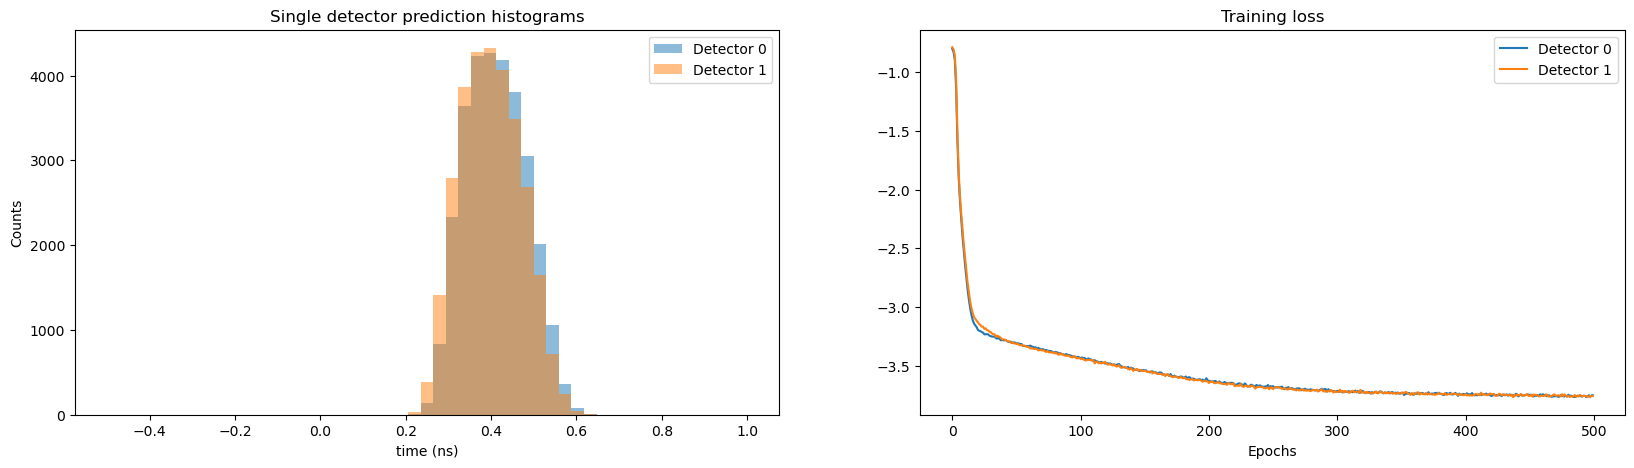

In [34]:
# Plot
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(test_dec0[-1, :], bins = nbins, range = [-0.5, 1], alpha = 0.5, label = 'Detector 0');
plt.hist(test_dec1[-1, :], bins = nbins, range = [-0.5, 1], alpha = 0.5, label = 'Detector 1');

plt.title('Single detector prediction histograms')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.legend()

plt.subplot(122)
plt.plot(np.log10(loss_dec0.astype('float32')), label = 'Detector 0')
plt.plot(np.log10(loss_dec1.astype('float32')), label = 'Detector 1')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.legend()

Plot the final TOF distribution results along their Gaussian fits and parameters.

CENTROID(ns) = -0.000 +/- 0.000  FWHM(ns) = 0.240 +/- 0.000



Text(0, 0.5, 'Counts')

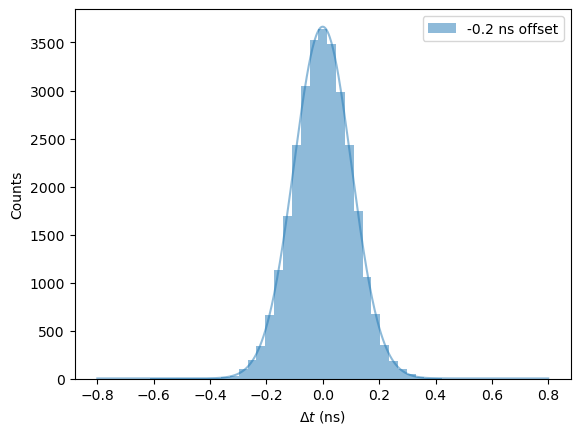

In [35]:
# Histogram and gaussian fit 
plot_gaussian(TOF[-1,:], centroid_V00[-1], range = 0.8, label = '-0.2 ns offset', nbins = nbins)
params, errors = get_gaussian_params(TOF[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
print("CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params[1], errors[2], params[2], errors[3]))

print('')
plt.legend()
plt.xlabel(r'$\Delta t$ (ns)')
plt.ylabel('Counts')